In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [7]:
input_image = tf.keras.layers.Input(shape=(784,))
encoded_input = tf.keras.layers.Dense(32, activation='relu')(input_image)
decoded_output = tf.keras.layers.Dense(784, activation='sigmoid')(encoded_input)
autoencoder = tf.keras.models.Model(input_image, decoded_output)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_train.shape[1:])))

In [16]:
autoencoder.fit(
    X_train,
    X_train,
    epochs=30,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1471 - val_loss: 0.1319
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1300 - val_loss: 0.1203
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1194 - val_loss: 0.1121
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1113 - val_loss: 0.1061
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1059 - val_loss: 0.1016
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1019 - val_loss: 0.0984
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0990 - val_loss: 0.0962
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0970 - val_loss: 0.0949
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0961 - val_loss: 0.0939
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0949 - val_loss: 0.0933
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0945 - val_loss: 0.0930
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


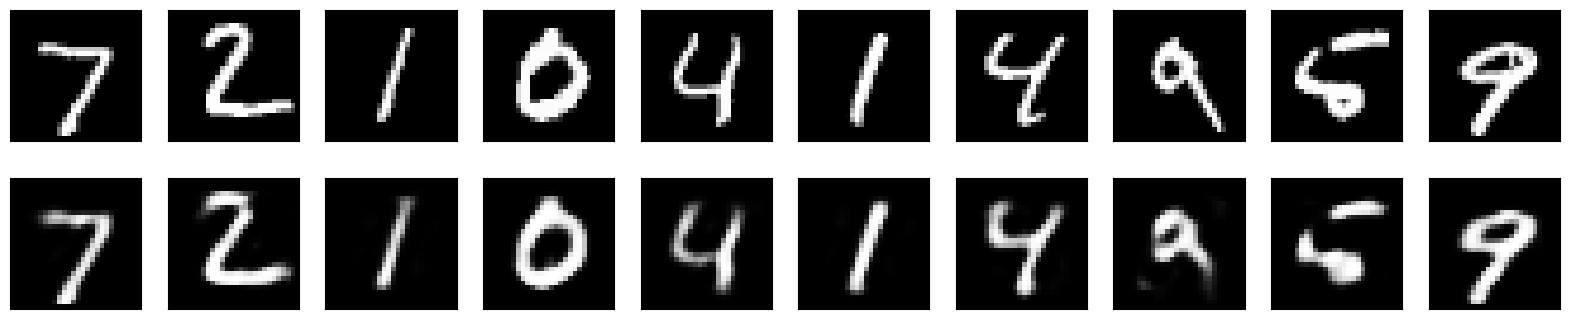

In [17]:
reconstructed_img = autoencoder.predict(X_test)
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(reconstructed_img[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions

/var/folders/nw/qdcvjm9j4vld91v373k868280000gn/T/ipykernel_10924/2086409671.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
TRAIN_BUF = 60000
TEST_BUF = 10000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(512))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(10000).batch(512))

In [13]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    
    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean
    
    def reconstruct(self, x):
        mu, _ =tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)
    
    def decode(self, z):
        return self.dec(z)
    
    def loss_function(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(loc=[0.]*z.shape[-1], scale_diag=[1.]*z.shape[-1])
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x-x_recon), axis=0))
        return recon_loss, latent_loss
    
    def gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.loss_function(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [14]:
encoder = [
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2*2)
]

decoder = [
    tf.keras.layers.Dense(units=7*7*64, activation='relu'),
    tf.keras.layers.Reshape(target_shape=(7,7,64)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding='SAME', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2,2), padding='SAME', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1,1), padding='SAME', activation='sigmoid'),
]

/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
model = VAE(
    enc=encoder,
    dec=decoder,
    optimizer=tf.keras.optimizers.Adam(1e-3)
)

In [16]:
example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=8, zm=2):
    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE,2)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm*nex, zm*3))
    for axi, (dat, lab) in enumerate(zip([example_data, example_data_reconstructed, samples], ['data', 'data recon', 'samples'])):
        for ex in range(nex):
            axs[axi, ex].matshow(dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

In [17]:
losses = pd.DataFrame(columns=['recon_loss', 'latent_loss'])

Epoch: 49 | recon_loss: 16.426292419433594 | latent_loss: 4.2004289627075195


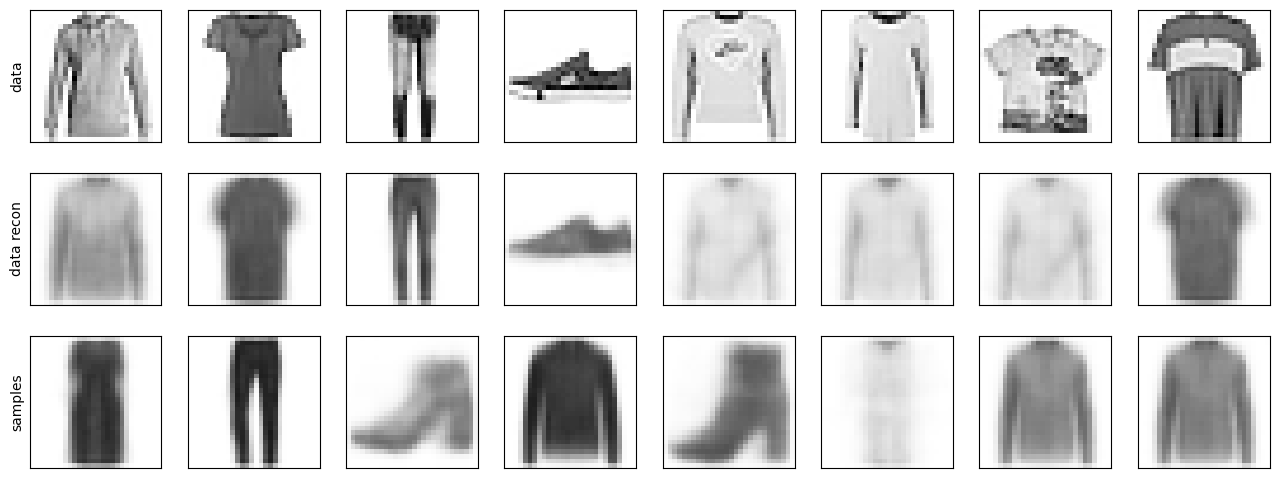

In [19]:
n_epochs = 50

for epoch in range(n_epochs):
    for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)
        loss = []

    for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
        loss.append(model.loss_function(train_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()

    print("Epoch: {} | recon_loss: {} | latent_loss: {}".format(epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]))

    plot_reconstruction(model, example_data)

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Dense, Dropout, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.datasets import mnist
import time
from IPython import display

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

In [23]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(7*7*256, input_dim=100))
    generator.add(LeakyReLU(0.2))    
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))
    return generator

g=create_generator()
g.summary()

/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,505 (8.75 MB)

 Trainable params: 2,293,121 (8.75 MB)

 Non-trainable params: 384 (1.50 KB)

In [24]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))   
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    return discriminator

d =create_discriminator()
d.summary()

/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    final_loss = real_loss + fake_loss
    return final_loss

def G_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [26]:
G_optimizer = tf.keras.optimizers.Adam()
D_optimizer = tf.keras.optimizers.Adam()

In [27]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 1

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [28]:
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='rainbow')

In [30]:
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        if epoch % 10 == 0:
            generate_images(generator, epoch+1, seed)
        print('에포크 {} 은/는 {} 초'.format(epoch+1, time.time()-start))
    
    generate_images(generator, epochs, seed)

2024-07-17 21:49:59.796132: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Exception ignored in: <function tqdm.__del__ at 0x1758c4900>
Traceback (most recent call last):
  File "/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/minwoo/miniconda3/envs/clean/lib/python3.11/site-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'


에포크 1 은/는 21.3227641582489 초


2024-07-17 21:50:21.815423: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


에포크 2 은/는 21.823160886764526 초
에포크 3 은/는 24.235397815704346 초


2024-07-17 21:51:11.470111: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


에포크 4 은/는 25.420205116271973 초
에포크 5 은/는 26.091313123703003 초
에포크 6 은/는 25.16340208053589 초
에포크 7 은/는 26.20678973197937 초


2024-07-17 21:52:53.478436: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


에포크 8 은/는 24.545374870300293 초
에포크 9 은/는 25.511355876922607 초
에포크 10 은/는 24.154964923858643 초
에포크 11 은/는 24.44114112854004 초
에포크 12 은/는 25.479991912841797 초
에포크 13 은/는 24.599303007125854 초
에포크 14 은/는 24.543454885482788 초
에포크 15 은/는 24.717870712280273 초


2024-07-17 21:56:12.353555: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


에포크 16 은/는 25.427057027816772 초
에포크 17 은/는 24.718406915664673 초
에포크 18 은/는 25.631349086761475 초
에포크 19 은/는 24.85695791244507 초
에포크 20 은/는 25.60173511505127 초
에포크 21 은/는 24.98381209373474 초
에포크 22 은/는 24.58481788635254 초
에포크 23 은/는 25.470057010650635 초
에포크 24 은/는 24.841737031936646 초
에포크 25 은/는 24.84567880630493 초
에포크 26 은/는 24.894480228424072 초
에포크 27 은/는 24.832733869552612 초
에포크 28 은/는 25.019450187683105 초
에포크 29 은/는 24.847803831100464 초
에포크 30 은/는 25.427933931350708 초


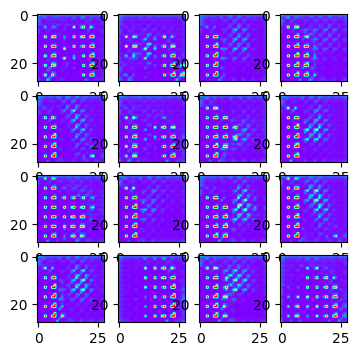

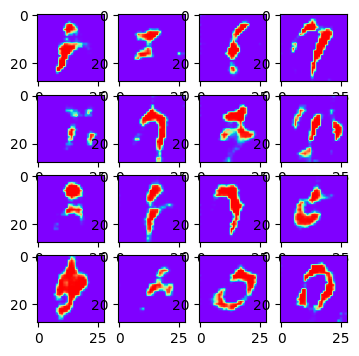

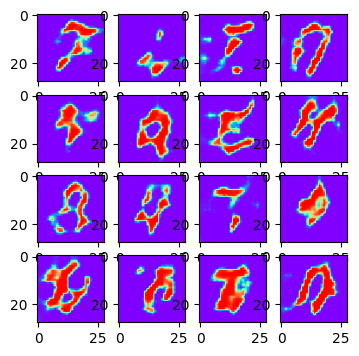

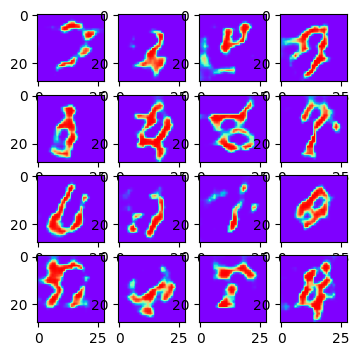

In [31]:
train_GAN(train_dataset, 30)